# Benchmark Testing Pre-Processing Methods: HOG

In this notebook, I will try to perform some benchmark test on different classifiers with HOG.

The procedure: <br>
**Load images - Grayscale - Center - Pre-Processing 1: HOG - Fit to Classifiers**

Classifiers to be tested:
- Logistic Regression
- kNN
- SVM
- CNN

In [1]:
# To modularise the program, we need to add the current directory to sys path
import os
import sys

# Navigate to where our modules are stored
os.chdir('/Users/gardar/Documents/UCL/ELEC0134 MLS-I Applied Machine Learning Systems/Assignments/Final/code')

# Now we can import our own modules into our script.
import import_data as ds
import split_dataset as sd 
import pre_processing as prp

# Standard packages for our ML framework
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Load Data

The data are stored in a local directory, we call a function to properly import them

Importing image data...
Image data is stored in numpy array 'X' of size: (5000, 218, 178, 3)
Importing labels...
Label data is stored in Pandas DataFrame 'y' with dimensions: (5000, 4)
Displaying random images and corresponding labels from set...


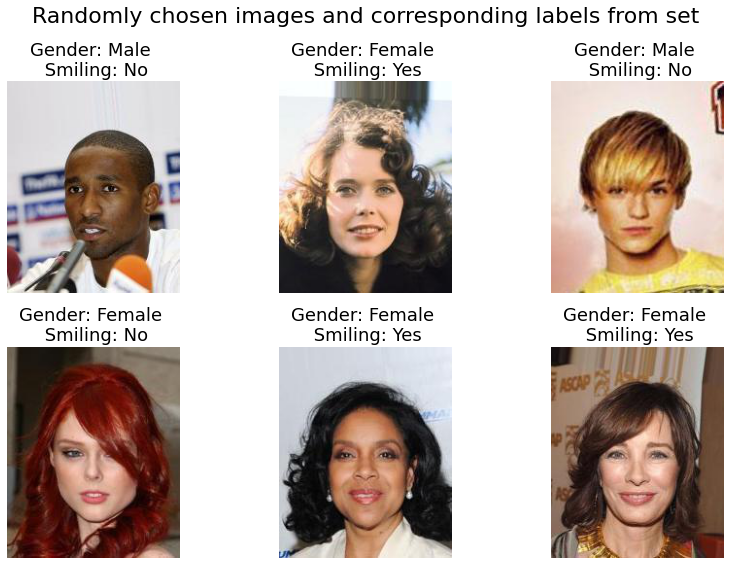

In [3]:
"""
L O A D   D A T A 
"""
# Define a path to the data - REMEMBER TO RESET THIS BEFORE TURNING IN
img_path = "/Users/gardar/Documents/UCL/ELEC0134 MLS-I Applied Machine Learning Systems/Assignments/dataset_AMLS_20-21/celeba/img/"
label_path = "/Users/gardar/Documents/UCL/ELEC0134 MLS-I Applied Machine Learning Systems/Assignments/dataset_AMLS_20-21/celeba/"

# Load image and label data with the novel 'import_data' module
X , y , random_img = ds.dataImport(img_path,label_path,surpress=False,return_img_indices=True)

### Split Data
We'll then split the data into training-, validation- and test folds.

Plotting the dataset split...


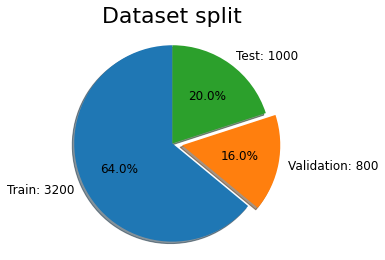

In [4]:
"""
S P L I T   D A T A
"""
    
# Split dataset into train-, validation- and test folds
Xtrain,Xval,Xtest,ytrain,yval,ytest = sd.split_dataset(X,y,test_size=0.2,val_size=0.2,surpress=False)

### Pre-Process Data
Prior to training our classifiers on the data, we perform pre-processing.
This involves some image processing, in the form of merging the RGB channels to a single Grayscale plane, centering the image data on the mean, and then performing principal component analysis with Singular Value Decomposition.

In [40]:
from skimage.feature import hog
from skimage import data, exposure

In [41]:
XtrainHOGdescriptor = []
XtrainHOGimg = []
XvalHOGdescriptor = []
XvalHOGimg = []
XtestHOGdescriptor = []
XtestHOGimg = []

### Generate HOG desriptor for: Training data

In [42]:
for i in range(len(Xtrain)):
    descriptor,image = hog(Xtrain[i], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    XtrainHOGdescriptor.append(descriptor)
    XtrainHOGimg.append(image)
    
XtrainHOGdescriptor = np.array(XtrainHOGdescriptor)

### Generate HOG desriptor for: Validation data

In [43]:
for i in range(len(Xval)):
    descriptor,image = hog(Xval[i], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    XvalHOGdescriptor.append(descriptor)
    XvalHOGimg.append(image)
    
XvalHOGdescriptor = np.array(XvalHOGdescriptor)

### Generate HOG desriptor for: Test data

In [44]:
for i in range(len(Xtest)):
    descriptor,image = hog(Xtest[i], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    XtestHOGdescriptor.append(descriptor)
    XtestHOGimg.append(image)
    
XtestHOGdescriptor = np.array(XtestHOGdescriptor)

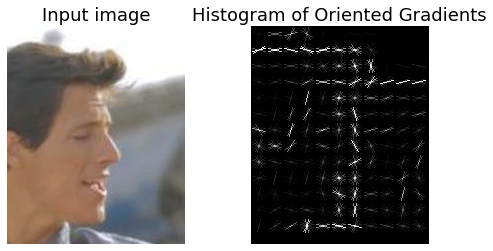

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(Xtest[0], cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(XtestHOGimg[0], in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

### Prepare Labels

In [48]:
# The labels are -1 = Female, 1 = Male
# Here, I'm transferring them to the space I € [0...1]
ytrain_A1 = ytrain['gender'].values[:]
ytrain_A1[ytrain_A1<0] = 0
yval_A1 = yval['gender'].values[:]
yval_A1[yval_A1<0] = 0
ytest_A1 = ytest['gender'].values[:]
ytest_A1[ytest_A1<0]=0

# The labels are -1 = Female, 1 = Male
# Here, I'm transferring them to the space I € [0...1]
ytrain_A2 = ytrain['smiling'].values[:]
ytrain_A2[ytrain_A2<0] = 0
yval_A2 = yval['smiling'].values[:]
yval_A2[yval_A2<0] = 0
ytest_A2 = ytest['smiling'].values[:]
ytest_A2[ytest_A2<0]=0

# Classifier: Logistic Regression

In [49]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [64]:
# sklearn functions implementation
def logRegrPredict(Xtrain,ytrain,Xtest, solver='lbfgs'):
    # Build Logistic Regression Model
    logreg = LogisticRegression(solver=solver) # lbfgs solver used for small datasets, 
    # Train the model using the training sets
    logreg.fit(Xtrain, ytrain)
    ypred= logreg.predict(Xtest)
    #print('Accuracy on test set: {:.2f}'.format(logreg.score(x_test, y_test)))
    return ypred

### Incrementally predict with different number of principal components and store accuracy scores

In [66]:
"""
P E R F O R M   L O G I S T I C   R E G R E S S I O N
"""
solvers2try = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']   
A1_LR_Accuracy = []
A2_LR_Accuracy = []

for solver in solvers2try:
    # A1 - Accuracy
    ypred_A1 = logRegrPredict(XtrainHOGdescriptor, ytrain_A1, XtestHOGdescriptor,solver=solver)
    A1_LR_Accuracy.append(accuracy_score(ytest_A1,ypred_A1))

    # A2 - Accuracy
    ypred_A2 = logRegrPredict(XtrainHOGdescriptor, ytrain_A2, XtestHOGdescriptor,solver=solver)
    A2_LR_Accuracy.append(accuracy_score(ytest_A2,ypred_A2))

A1_LR_Accuracy = np.array(A1_LR_Accuracy)    
A2_LR_Accuracy = np.array(A2_LR_Accuracy)

/opt/anaconda3/envs/MLS-I/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/MLS-I/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

### Report results, i.e. which solver yields best results

In [119]:
pd.DataFrame((A1_LR_Accuracy*100,A2_LR_Accuracy*100),columns=solvers2try, index = ['Task A1','Task A2'])

,liblinear,newton-cg,lbfgs,sag,saga
Task A1,87.3,87.3,87.3,87.4,87.6
Task A2,83.4,83.6,83.1,83.4,83.4


# Classifier: kNN

In [120]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def KNNClassifier(Xtrain, ytrain, Xtest,k):

    #Create KNN object with a K coefficient
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(Xtrain, ytrain) # Fit KNN model


    ypred = neigh.predict(Xtest)
    return ypred

## Task A1 & A2

In [126]:
k_range = np.arange(1,50+1,1)
A1_kNN_Accuracy = []
A2_kNN_Accuracy = []

for k in k_range:
    ypred=KNNClassifier(XtrainHOGdescriptor, ytrain_A1, XtestHOGdescriptor,k)
    A1_kNN_Accuracy.append(metrics.accuracy_score(ytest_A1,ypred))
    
    ypred=KNNClassifier(XtrainHOGdescriptor, ytrain_A2, XtestHOGdescriptor,k)
    A2_kNN_Accuracy.append(metrics.accuracy_score(ytest_A2,ypred))
    
A1_kNN_Accuracy = np.array(A1_kNN_Accuracy)
A2_kNN_Accuracy = np.array(A2_kNN_Accuracy)

## Report results

In [148]:
fig,ax = plt.subplots(2, figsize = (16,10))

ax[0].plot(k_range,A1_kNN_Accuracy,marker='o')

xyMax = {'x': k_range[np.argmax(A1_kNN_Accuracy)], 
         'y': A1_kNN_Accuracy.max()
        }

ax[0].plot(xyMax['x'],xyMax['y'],'ro',markersize=14)
ax[0].annotate("Components: {}\nAccuracy: {:.1f}%".format(xyMax['x'],xyMax['y']*100),(xyMax['x']+4.5,xyMax['y']-0.005))
ax[0].grid("on")
ax[0].set_title("Task A1 - Gender Detection")

ax[1].plot(k_range,A2_kNN_Accuracy,marker='o')

xyMax = {'x': k_range[np.argmax(A2_kNN_Accuracy)], 
         'y': A2_kNN_Accuracy.max()
        }

ax[1].plot(xyMax['x'],xyMax['y'],'ro',markersize=14)
ax[1].annotate("Components: {}\nAccuracy: {:.1f}%".format(xyMax['x'],xyMax['y']*100),(xyMax['x']-4,xyMax['y']-0.025))
ax[1].grid("on")
ax[1].set_title("Task A2 - Smile Detection")

plt.suptitle("HOG with k-Nearest Neighbours")
plt.tight_layout()
fig.set_dpi(800)
plt.show()

# Classifier: SVM

In [158]:
from sklearn import svm

In [159]:
clf = svm.SVC()

In [162]:
A1_SVM_accuracy = 0.
A2_SVM_accuracy = 0.

# Training the decision tree classifier on training set. 
clf.fit(XtrainHOGdescriptor,ytrain_A1)

# Predicting labels on the test set.
ypred_A1 = clf.predict(XtestHOGdescriptor)
A1_SVM_accuracy = (accuracy_score(ytest_A1,ypred_A1))
print('Task A1 - Accuracy score on the test data: {:.1f}%'.format(A1_SVM_accuracy*100))

# Training the decision tree classifier on training set. 
clf.fit(XtrainHOGdescriptor,ytrain_A2)

# Predicting labels on the test set.
ypred_A2 = clf.predict(XtestHOGdescriptor)
A2_SVM_accuracy = (accuracy_score(ytest_A2,ypred_A2))

print('Task A2 - Accuracy score on the test data: {:.1f}%'.format(A2_SVM_accuracy*100))

Task A1 - Accuracy score on the test data: 87.8%
Task A2 - Accuracy score on the test data: 82.2%


### Task A1: Tune Hyper Parameters

In [164]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100,1000],  
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['linear']
             }  
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(XtrainHOGdescriptor, ytrain_A1) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.867, total=   4.6s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.858, total=   4.7s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.875, total=   4.8s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.864, total=   4.7s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.872, total=   4.9s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.867, total=   4.7s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.858, total=   4.8s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.875, total=   5.1s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.864, total=   5.1s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .

[CV] ....... C=100, gamma=1, kernel=linear, score=0.842, total=   4.5s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.831, total=   4.5s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.839, total=   4.6s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.822, total=   4.5s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.820, total=   4.5s
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] ..... C=100, gamma=0.1, kernel=linear, score=0.842, total=   4.5s
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] ..... C=100, gamma=0.1, kernel=linear, score=0.831, total=   4.5s
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  7.6min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear']},
             verbose=3)

In [172]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
SVC(C=0.1, gamma=1, kernel='linear')


In [173]:
tuned_HP = grid.best_params_

In [174]:
tuned_SVM = svm.SVC(**tuned_HP)

In [175]:
tuned_SVM.fit(XtrainHOGdescriptor, ytrain_A1)

SVC(C=0.1, gamma=1, kernel='linear')

In [184]:
ypred = tuned_SVM.predict(XtestHOGdescriptor)

In [185]:
print('Accuracy Score on train data: ', accuracy_score(y_true=ytrain_A1, y_pred=tuned_SVM.predict(XtrainHOGdescriptor)))
print('Accuracy Score on the test data: ', accuracy_score(y_true=ytest_A1, y_pred=ypred))

Accuracy Score on train data:  0.946875
Accuracy Score on the test data:  0.868


In [186]:
# print prediction results 
print(metrics.classification_report(ytest_A1, ypred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       511
           1       0.87      0.87      0.87       489

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



### Task A2: Tune Hyper Parameters

In [187]:
clf = svm.SVC()

In [188]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100,1000],  
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['linear']
             } 
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(XtrainHOGdescriptor, ytrain_A2) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.833, total=   6.4s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.805, total=   6.2s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.6s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.794, total=   6.2s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.817, total=   6.6s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.792, total=   6.4s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.833, total=   6.5s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.805, total=   6.4s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.794, total=   6.4s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.817, total=   6.6s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .

[CV] ....... C=100, gamma=1, kernel=linear, score=0.781, total=   5.9s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.775, total=   6.0s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.741, total=   5.8s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.750, total=   5.9s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.747, total=   5.8s
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] ..... C=100, gamma=0.1, kernel=linear, score=0.781, total=   5.9s
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] ..... C=100, gamma=0.1, kernel=linear, score=0.775, total=   6.0s
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.0min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear']},
             verbose=3)

In [189]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
SVC(C=0.1, gamma=1, kernel='linear')


In [190]:
tuned_HP = grid.best_params_

In [191]:
tuned_SVM = svm.SVC(**tuned_HP)

In [193]:
tuned_SVM.fit(XtrainHOGdescriptor, ytrain_A2)

SVC(C=0.1, gamma=1, kernel='linear')

In [194]:
ypred = tuned_SVM.predict(XtestHOGdescriptor)

In [195]:
print('Accuracy Score on train data: ', accuracy_score(y_true=ytrain_A2, y_pred=tuned_SVM.predict(XtrainHOGdescriptor)))
print('Accuracy Score on the test data: ', accuracy_score(y_true=ytest_A2, y_pred=ypred))

Accuracy Score on train data:  0.9215625
Accuracy Score on the test data:  0.829


In [196]:
# print prediction results 
print(metrics.classification_report(ytest_A2, ypred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       507
           1       0.83      0.82      0.82       493

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



### Conclusion
SVMs may be used to obtain 80-90% accuracy on the data with PCA

# Classifier: CNN

In [514]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.optimizers import RMSprop

In [515]:
batch_size = 128
num_classes = 2
epochs = 100

In [516]:
"""
U S E   T H E   W H O L E   G R A Y S C A L E   I M A G E S 
"""

# Principal components to retain
XtrainPC = Xtrain
XvalPC = Xval
XtestPC = Xtest

# Scale
XtrainScl = scaler.fit_transform(XtrainPC)
XvalScl = scaler.fit_transform(XvalPC)
XtestScl = scaler.fit_transform(XtestPC)

In [517]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(38804,)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [518]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 1024)              39736320  
_________________________________________________________________
dense_37 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_38 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_39 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 514       
Total params: 41,442,562
Trainable params: 41,442,562
Non-trainable params: 0
_________________________________________________________________


In [519]:
# Transform labels for CNN categorical_crossentropy
from keras.utils import to_categorical

ytrain_bin_A1 = to_categorical(ytrain_A1)
yval_bin_A1 = to_categorical(yval_A1)
ytest_bin_A1 = to_categorical(ytest_A1)

In [520]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])


history = model.fit(XtrainScl, ytrain_bin_A1,batch_size=batch_size,epochs=epochs,verbose=1,
                    validation_data=(XvalScl, yval_bin_A1))

Train on 3200 samples, validate on 800 samples
Epoch 1/100
3200/3200 [==============================] - 10s 3ms/step - loss: 32.2500 - accuracy: 0.5075 - val_loss: 1.0932 - val_accuracy: 0.5000
Epoch 2/100
3200/3200 [==============================] - 10s 3ms/step - loss: 1.0838 - accuracy: 0.5166 - val_loss: 0.7650 - val_accuracy: 0.5000
Epoch 3/100
1920/3200 [=================>............] - ETA: 4s - loss: 0.7518 - accuracy: 0.4953

KeyboardInterrupt: 

In [ ]:
ypred = model.predict_classes(XtestScl)

In [ ]:
print('Accuracy Score on the test data: ', accuracy_score(y_true=ytest_A1, y_pred=ypred))